<a href="https://colab.research.google.com/github/prakashbhattgit/2020-CS109B/blob/master/NLP_Prakash_Bhatt_assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Neural Networks and Embeddings
#Prakash C Bhatt
#Due 7/13/2020
#Prof Benjamin Batorsky 





In this assignment, you will apply some of the techniques you learned in class to build a performant sentiment analysis model and compare performance across approaches.

> This dataset comes from [Mass et. al. (2011)](https://www.aclweb.org/anthology/P11-1015.pdf) and the full version is available [here](http://ai.stanford.edu/~amaas/data/sentiment/).

#Imports

## Installations

In [ ]:
!pip install glove_python

## Google Imports

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [1]:
%cd /gdrive/'My Drive'/ColabHome/NLP/Assignment-03
!pwd
!ls 

/gdrive/My Drive/ColabHome/NLP/Assignment-03
/gdrive/My Drive/ColabHome/NLP/Assignment-03
 assignment_1_reviews.pkl  'NLP Prakash Bhatt assignment_3.ipynb'
 assignment_3.ipynb	    week_3_context.ipynb
 glove.model		   'Week 3 notebook (student version).ipynb'
 glove_words.plk


In [ ]:
#!cp ../homework-02/assignment_1_reviews.pkl . 


## Library imports

In [2]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re


required = {'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 'matplotlib'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import spacy
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
import pickle
import matplotlib.pyplot as plt

from spacy.lang.en import English
en = English()

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
# this will set the device on which to train
device = torch.device("cpu")
# if using collab, set your runtime to use GPU and use the line below
#device = torch.device("cuda:0")

def simple_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents (different from above)
    tokenized_docs = []
    parsed = model(doc)
    return([t.lower_ for t in parsed if (t.is_alpha)&(not t.like_url)])

## Common built classes and functions libraries

In [92]:
def simple_class_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents (different from above)
    tokenized_docs = []
    parsed = model(doc)
    return([t.lemma_.lower() for t in parsed if (t.is_alpha)&(not t.like_url) & (not t.is_stop)] )

# Choosing an embedding
In class, we discussed several options for word embeddings.

- One-hot encoding vectors
- NMF/LDA topics at the word level
- Pre-trained GloVe vectors from SpaCy

These embeddings can compared to one another to assess similarity between words.  We did some of this in the class.  But, a lot of the interesting exploration of these embeddings comes from visualizing them in space.  

In the [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) paper, part of their evaluation of performance is to do some vector algebra (e.g. king-man+woman=queen).  This depends on a clear spatial relationship between word vectors.  Let's evaluate the spatial relationship by plotting some particular words.  Let's do this with GloVe and with our NMF/LDA topic model word embeddings.

Tip: If you're not familiar with [matplotlib](https://matplotlib.org/), you'll likely need to look up how to [put together a scatterplot](https://pythonspot.com/matplotlib-scatterplot) and, additionally, how to [annotate it with text](https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point).

Tip \#2: I'm putting some suggested seed words here, but try and think of your own.  Also feel free to do your own explorations.  Any particularly interesting ones I'll include in class next week.  Be creative here, exploratory data analysis with embeddings is something I don't think gets enough attention.


## Extracting tokens and sentences from the movie reviews

In [6]:
nlp = spacy.load("en_core_web_sm")
        
data_location = './assignment_1_reviews.pkl'
with open(data_location, 'rb') as f:
    all_text = pickle.load(f)
neg, pos = all_text.values()
all_text = neg+pos
all_tokenized = [simple_class_tokenizer(line) for line in all_text ]


## Exploring tokens 

In [17]:
glove_words = [nlp(word).vector for line in all_tokenized for word in line]
print(glove_words[0][:10])
print(glove_words[0].shape)

[ 1.0853081  -0.95277804 -0.52203417 -0.22894484  3.8408265  -0.52309185
  2.2309175  -0.7608305   0.00918591  3.0352554 ]
(96,)


In [22]:
type(glove_words),len(glove_words),glove_words[0].shape

(list, 248274, (96,))

In [25]:
glove_words_array = np.array(glove_words)

In [26]:
glove_words_array.shape

(248274, 96)

In [23]:
# Pickling all the words
# with open('./glove_words.plk','wb') as file:
#     pickle.dump(glove_words,file)

## Implementing Word2Vec in Glove

In [112]:
from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
corpus  = []
_ = [corpus.append(word) for lines in all_tokenized for word in lines]
corpus = set(corpus)
len(corpus)


26778

In [ ]:
all_tokenized[0:1]

In [154]:
sent2vec = word2vec.Word2Vec(all_tokenized, size=100, window=5, min_count=50, workers=4)
labels = []
tokens = []

for word in sent2vec.wv.vocab:
    tokens.append(sent2vec[word])
    labels.append(word)

In [158]:
#sent2vec.wv.wv['good']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


array([ 0.12183482, -0.01793452, -0.2483809 ,  0.07125825,  0.03719885,
       -0.2524811 , -0.09098325,  0.13061626,  0.18781747, -0.03289261,
        0.1534665 , -0.11996142,  0.07116304,  0.24730217, -0.26734036,
        0.28791103,  0.16016522, -0.16362254,  0.05004342,  0.01130571,
       -0.22928193,  0.01017189, -0.00805153,  0.02022625,  0.06537402,
        0.12783808,  0.0757364 ,  0.00251161, -0.02006913, -0.27625898,
       -0.27289596, -0.3738165 ,  0.09810195,  0.0401023 ,  0.1172789 ,
       -0.10834204, -0.14358857,  0.00735426, -0.17358784,  0.112647  ,
        0.2368223 , -0.07608461,  0.1498621 , -0.19235621,  0.12099719,
        0.4352034 ,  0.04290011,  0.3084039 , -0.26219618, -0.03684418,
        0.03831683, -0.16556068, -0.1093272 ,  0.33441123, -0.26889282,
       -0.02475898, -0.09647426,  0.01081829,  0.06068349, -0.00945516,
       -0.01019792,  0.03239455, -0.13124599,  0.01804616,  0.17654651,
       -0.11368807,  0.14060555,  0.07826505,  0.2688595 ,  0.00

In [156]:
len(tokens), tokens[0], "\n"

(878, array([ 0.1326498 , -0.0439868 , -0.2339319 ,  0.08051775,  0.05005715,
        -0.24434263, -0.07976211,  0.13111813,  0.17197351, -0.04535361,
         0.1695104 , -0.14835241,  0.03972001,  0.2803073 , -0.22636095,
         0.25852397,  0.1947326 , -0.15151682,  0.07340477,  0.01436011,
        -0.20506962,  0.02104331, -0.05010747,  0.02413628,  0.04471988,
         0.11004326,  0.0684288 ,  0.02189423,  0.00242726, -0.2641763 ,
        -0.25773054, -0.36275622,  0.10913324, -0.01480986,  0.13215396,
        -0.11911876, -0.19000962,  0.0317663 , -0.15075965,  0.08912688,
         0.27144557, -0.04396939,  0.17854014, -0.17881817,  0.14450906,
         0.41499478,  0.00529442,  0.3531866 , -0.23685333,  0.01013912,
         0.0611629 , -0.16171928, -0.08852167,  0.3405327 , -0.30390054,
        -0.00247041, -0.11235809,  0.00586096,  0.06780504, -0.00770309,
        -0.01080107,  0.02567926, -0.17896585,  0.03615661,  0.17921211,
        -0.12279247,  0.10037542,  0.0491081 ,

In [ ]:
labels

### Defining TSNE model

In [196]:
def glove_fit_and_plot(size,window,min_count,start_range=0, end_range="" ):

    sent2vec = word2vec.Word2Vec(all_tokenized, size=100, window=5, min_count=50, workers=10)
    labels = []
    tokens = []

    for word in sent2vec.wv.vocab:
        tokens.append(sent2vec[word])
        labels.append(word)

    #Model

    #fit the model

    #crate TSNE
    tsne = TSNE(n_components=2, perplexity=40,n_iter=2500,random_state=41)
    
    # Fit TSNE
    tsne_comp = tsne.fit_transform(tokens)

    # Plot TSNE

    x, y = [], []
    _= [(x.append(value[0]) , y.append(value[1]) ) for value in tsne_comp] 
    #_= [ y.append(value[1]for value in tsne_comp] 
                      
    fig = plt.figure(figsize=(20,10))
    if not end_range: end_range = len(x)

    for i in range(start_range, end_range):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy = (x[i],y[i]), xytext=(5,2), textcoords = 'offset points',ha='right',va='bottom')


    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


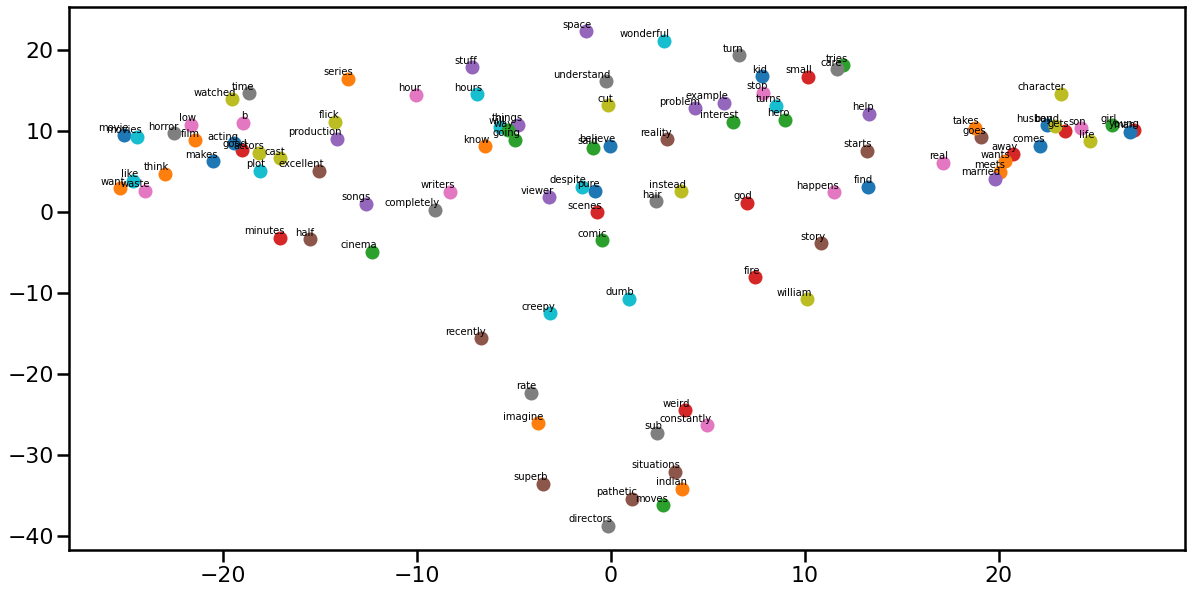

In [199]:
_= glove_fit_and_plot(50,5,20,0,100)  # size, window , min_count, start_range, end_range


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


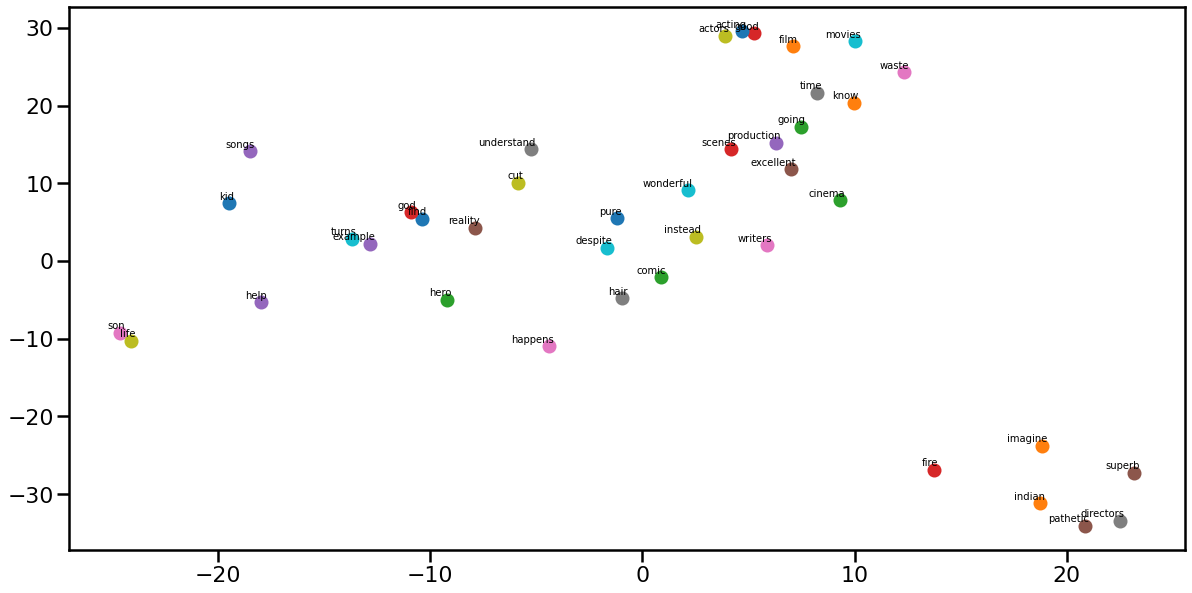

In [201]:
_= glove_fit_and_plot(50,5,20,40,80)  # size, window , min_count, start_range, end_range


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


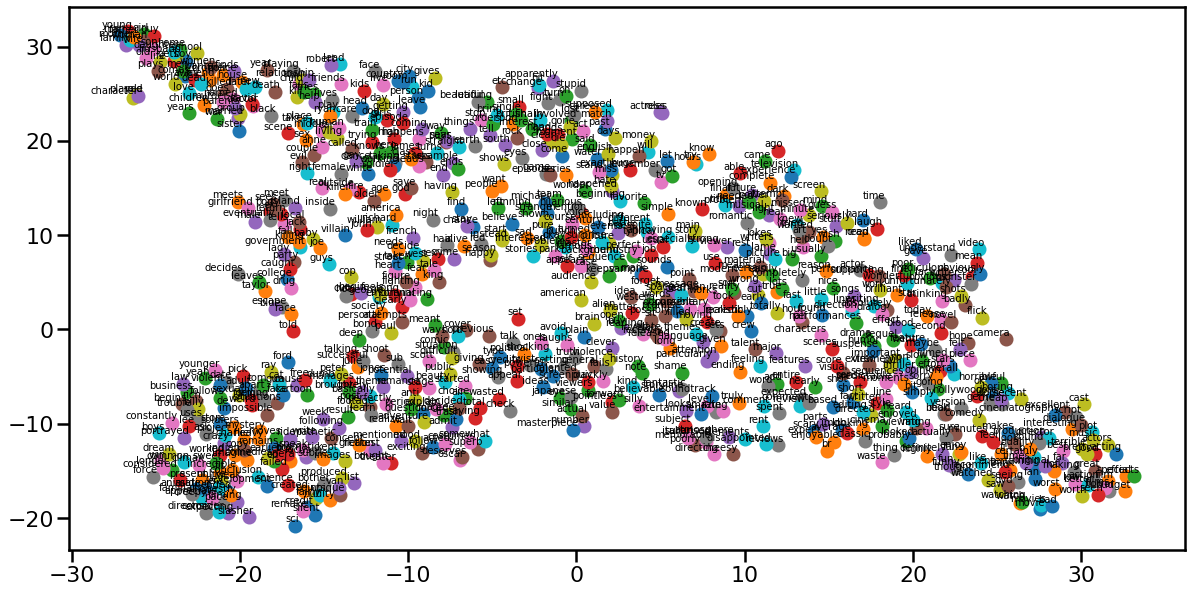

In [197]:
_= glove_fit_and_plot(100,5,50)  # size, window , min_count


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


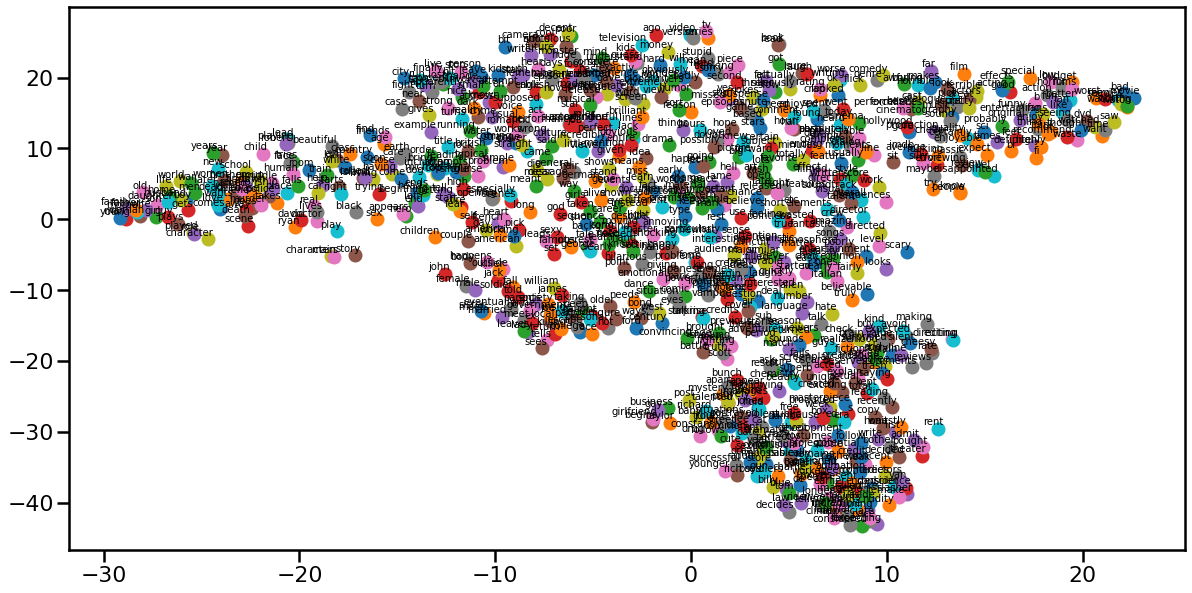

In [175]:
_= glove_fit_and_plot(50,5,20)  # size, window , min_count


In [178]:
sent2vec.wv.most_similar('beautiful')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('tells', 0.9994289875030518),
 ('ex', 0.9994248151779175),
 ('train', 0.999390721321106),
 ('ryan', 0.9993799328804016),
 ('anne', 0.9993786811828613),
 ('leaves', 0.99937504529953),
 ('class', 0.9993695020675659),
 ('robert', 0.9993475675582886),
 ('body', 0.9993448853492737),
 ('strong', 0.9993411898612976)]

In [179]:
sent2vec.wv.most_similar('movie')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('watch', 0.9964573979377747),
 ('movies', 0.9961321949958801),
 ('bad', 0.9960396885871887),
 ('watching', 0.9944151043891907),
 ('seen', 0.9928328394889832),
 ('worst', 0.9912412166595459),
 ('worth', 0.990540623664856),
 ('good', 0.9902483224868774),
 ('better', 0.9901803731918335),
 ('thought', 0.9882723093032837)]

In [180]:
sent2vec.wv.most_similar('good')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('great', 0.9978510141372681),
 ('better', 0.9977351427078247),
 ('worst', 0.9974912405014038),
 ('terrible', 0.9968400001525879),
 ('fun', 0.9968082904815674),
 ('pretty', 0.9967583417892456),
 ('thought', 0.9966455698013306),
 ('films', 0.9966096878051758),
 ('actors', 0.9964817762374878),
 ('bad', 0.9963803291320801)]

In [184]:
def connection_words(start1, end1, end2):
    sim = sent2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = sim[0][0]
    print("{start1} --is to --> {end1}, as {start2} --is to--> {end2}".format(**locals()))
    return start2

In [185]:
connection_words('movie','good','actor')

movie --is to --> good, as thought --is to--> actor


'thought'

In [186]:
connection_words('actor','like','movie')

actor --is to --> like, as good --is to--> movie


'good'

In [193]:
connection_words('house','good','bad')

house --is to --> good, as hours --is to--> bad


'hours'

## Word2vec with gensim

In [56]:
from gensim.models import word2vec as w2v 
import sklearn.manifold
import seaborn as sns 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
all_tokenized_words=[]
_ = [ all_tokenized_words.append(word) for line in all_tokenized for word in line ]

In [33]:
word_count = len(all_tokenized_words)

In [35]:
vocab = set (all_tokenized_words)
len(vocab)

26778

In [36]:
# number of features 
num_features = 300


In [49]:
sent2vec = w2v.Word2Vec(sg =11, seed =21, workers=5, size = num_features,window=5, min_count=3)

In [50]:
sent2vec.build_vocab(all_tokenized)

In [54]:
sent2vec.train(all_tokenized,total_words=word_count,epochs=5)

(1093107, 1241370)

In [61]:
#Initiate TSNE
tsne = sklearn.manifold.TSNE(n_components =2, random_state =2)
#Making all the matrix in two dimension
all_word_vector_matrix = sent2vec.wv.syn0
#training TSNE
all_word_vector_matrix_2c = tsne.fit_transform(all_word_vector_matrix)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


In [72]:
df = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vector_matrix_2c[sent2vec.wv.vocab[word].index])
            for word in sent2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [73]:
df.head()

,word,x,y
0,movie,-67.698044,-54.985180
1,mini,-51.801464,-31.970852
2,series,-72.058746,-45.533184
3,tries,71.728241,-32.671829
4,information,-9.140979,-47.864586


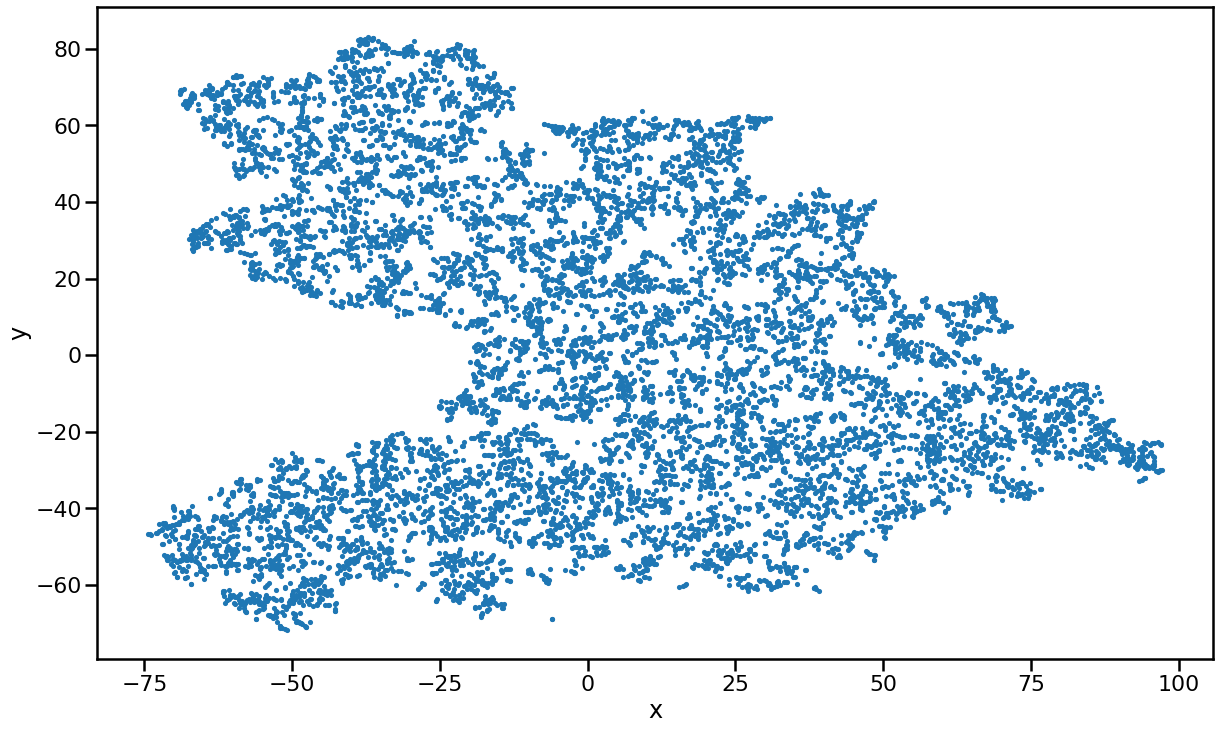

In [76]:
sns.set_context('poster')
df.plot.scatter("x", "y", s=10, figsize=(20, 12))


In [90]:
def plot_region(x_bounds, y_bounds):
    slice =df [
        (x_bounds[0] <= df.x) &
        (df.x <= x_bounds[1]) & 
        (y_bounds[0] <= df.y) &
        (df.y <= y_bounds[1])
    ]
    #slice = np.array(slice)
    ax = slice.plot.scatter("x", "y", s=35, figsize=(20, 10))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

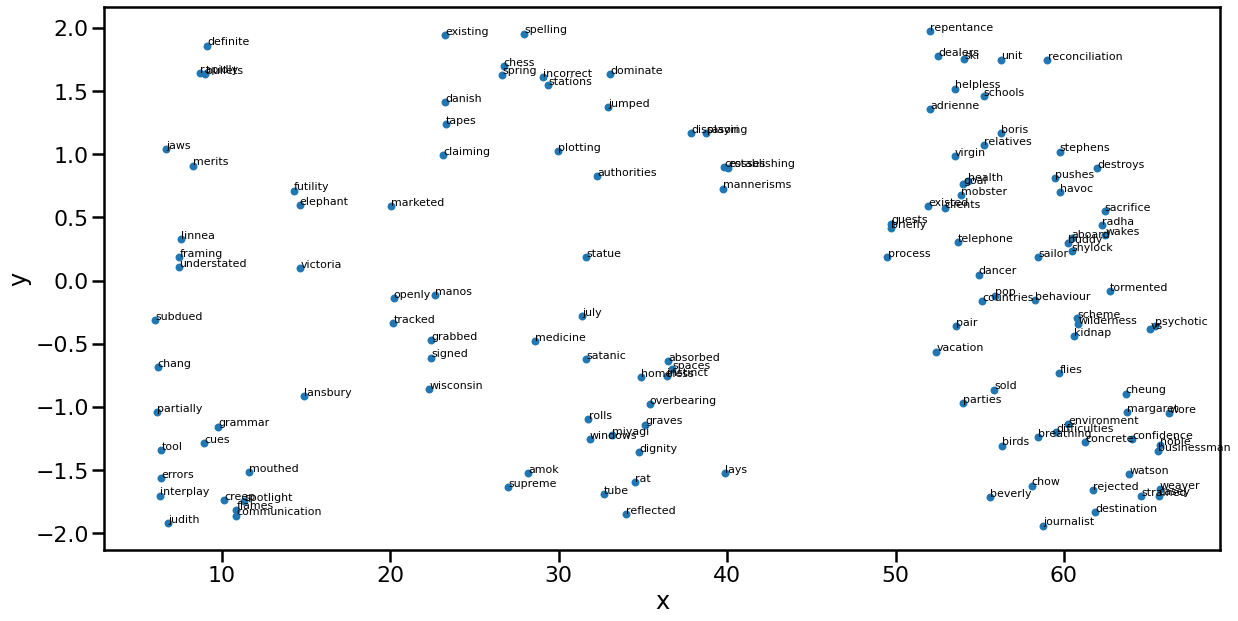

In [94]:
plot_region(x_bounds=(4.0, 1000), y_bounds=(-2, +2))


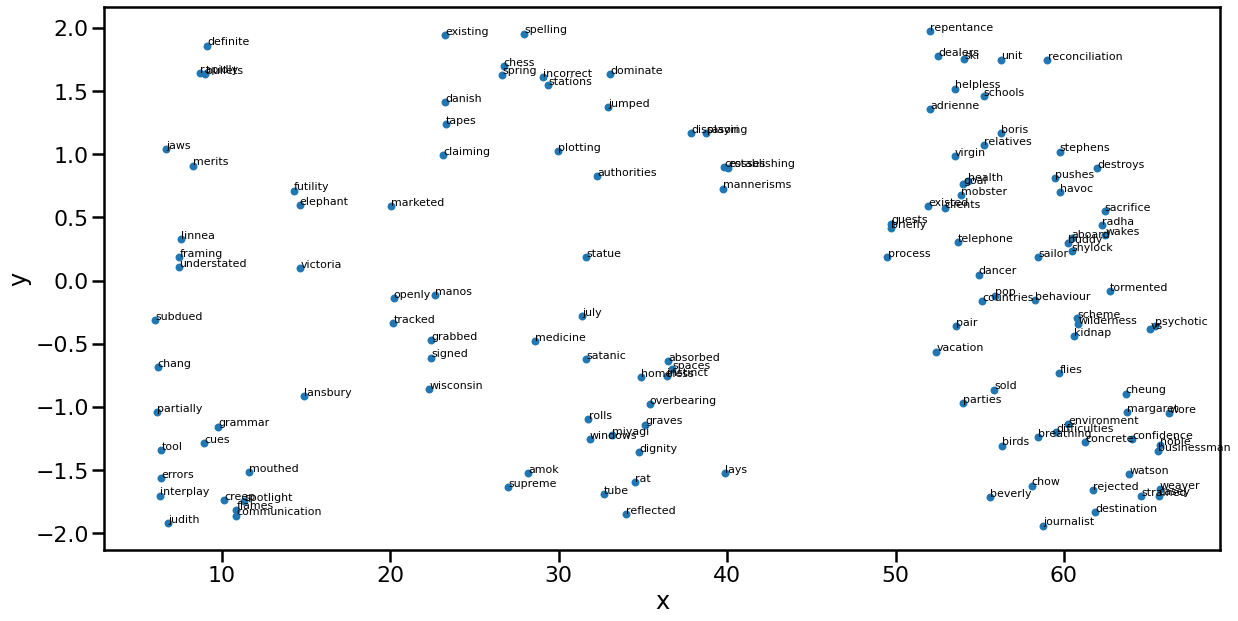

In [95]:
plot_region(x_bounds=(4.0, 100), y_bounds=(-2, +2))


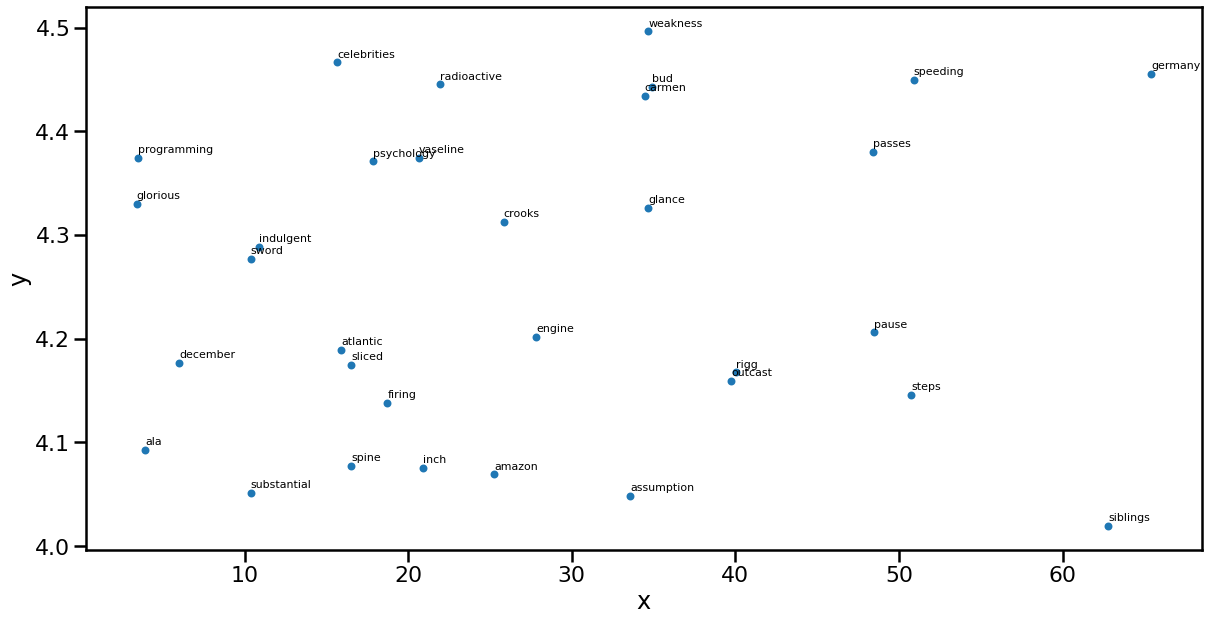

In [97]:
plot_region(x_bounds=(0, 100), y_bounds=(4, 4.5))


In [98]:
sent2vec.most_similar("titanic")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('harm', 0.999728798866272),
 ('painting', 0.9997018575668335),
 ('heaven', 0.9996778964996338),
 ('screens', 0.9996770620346069),
 ('consigned', 0.9996752142906189),
 ('qualify', 0.999671220779419),
 ('aimed', 0.9996688365936279),
 ('flowing', 0.99965900182724),
 ('ins', 0.9996567964553833),
 ('consideration', 0.9996506571769714)]

In [99]:
sent2vec.most_similar("horror")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('genre', 0.9789692759513855),
 ('fi', 0.9727296233177185),
 ('sci', 0.972467839717865),
 ('fan', 0.9710553288459778),
 ('hollywood', 0.962618887424469),
 ('slasher', 0.9572721719741821),
 ('channel', 0.9570972919464111),
 ('b', 0.9549679756164551),
 ('flick', 0.9546896815299988),
 ('fans', 0.9544184803962708)]

In [101]:
sent2vec.most_similar("star")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('known', 0.9616626501083374),
 ('trek', 0.9563285708427429),
 ('stars', 0.9563007354736328),
 ('oscar', 0.9450153708457947),
 ('award', 0.9442342519760132),
 ('director', 0.9433870911598206),
 ('musical', 0.9416790008544922),
 ('directed', 0.9384207725524902),
 ('western', 0.9338768124580383),
 ('career', 0.932502806186676)]

In [108]:
def similar_words(start1, end1, end2):
    sim = sent2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = sim[0][0]
    print("{start1} --is to --> {end1}, as {start2} --is to--> {end2}".format(**locals()))
    return start2

In [109]:
similar_words("titanic","ocean","star")

titanic --is to --> ocean, as known --is to--> star


'known'

In [110]:
similar_words("star","scifi","good")

star --is to --> scifi, as actors --is to--> good


'actors'

In [111]:
similar_words('good','movie','bad')

good --is to --> movie, as poor --is to--> bad


'poor'

## from examples on the website (delete it later?)

In [ ]:
from glove import Corpus, Glove

In [ ]:
corpus = Corpus()
corpus.fit(all_tokenized,window =10 )
glove = Glove(no_components=5, learning_rate=0.05)
glove.fit(corpus.matrix, epochs = 20, no_threads =4, verbose= True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

In [ ]:
glove.dictionary

In [ ]:
glove.most_similar( positive =['movie','good'],negative =['film'])

##  Working with spacy Word2vec

In [ ]:
!python  -m spacy download en_core_web_md

In [ ]:
import en_core_web_md
nlp  = en_core_web_md.load() 

In [ ]:
glove_words = [nlp(w).vector for w in seed_words]
# each vector is 300-dimensional dense representation
print(glove_words[0][:10])
print(glove_words[0].shape)

[-0.42625   0.4431   -0.34517  -0.1326   -0.05816   0.052598  0.21575
 -0.36721  -0.04519   2.2444  ]
(300,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


<function matplotlib.pyplot.show>

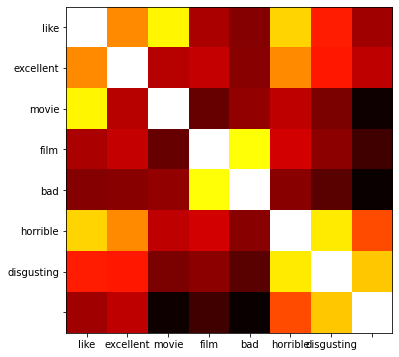

In [ ]:
fig   = plt.figure(figsize = (6,6))

cos = cosine_similarity(glove_words)
plt.imshow(cos, cmap='hot', interpolation='nearest')
axs = fig.add_subplot(1,1,1)
axs.set_xticklabels(seed_words)
axs.set_yticklabels(seed_words)
plt.show

 #### Results

 >we are finding a good similarity results with the too.

 >Lighter the colers are more similar they are 

## Embedding with CV, TFIDF, NMF and LDA

In [4]:
data_location = './assignment_1_reviews.pkl'
with open(data_location, 'rb') as f:
    all_text = pickle.load(f)
neg, pos = all_text.values()

all_text = neg+pos
all_tokenized = [simple_class_tokenizer(line) for line in all_text ]

all_reviews = np.array(all_text)


In [10]:
type(all_reviews)

numpy.ndarray

In [5]:
all_tokenized_words = []
_ = [ all_tokenized_words.append(word) for line in all_tokenized for word in line ]
len(set(all_tokenized_words))

26778

### Getting embedding of the complete corp

In [44]:
n_components = 20

tfidf = TfidfVectorizer(tokenizer=simple_class_tokenizer,max_features=n_components)
 

nmf = NMF(n_components=n_components)



tfidf_vecs = tfidf.fit_transform(all_text)


nmf_vecs = nmf.fit_transform(tfidf_vecs)



In [45]:
#Showing part of the features for NMF
 
tfidf.get_feature_names() 

['bad',
 'best',
 'br',
 'character',
 'characters',
 'film',
 'films',
 'good',
 'great',
 'know',
 'like',
 'love',
 'movie',
 'movies',
 'people',
 'story',
 'think',
 'time',
 'watch',
 'way']

In [48]:
#Showing part of the features for NMF
df = pd.DataFrame(nmf_vecs ,columns=tfidf.get_feature_names() )
df.head(4)

,bad,best,br,character,characters,film,films,good,great,know,like,love,movie,movies,people,story,think,time,watch,way
0,0.053001,0.000000,0.097312,0.130962,0.000000,0.0,0.0,0.071412,0.0,6.565566e-20,0.0,0.0,4.574871e-16,0.0,0.000000,0.0,0.000000,1.919946e-01,0.000000,0.000000
1,0.097673,0.115757,0.000000,0.048286,0.100229,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,5.464555e-02,0.0,0.062063,0.0,0.080949,7.078875e-02,0.000000,0.076129
2,0.123122,0.081037,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.000000,0.000000e+00,0.136101,0.000000
3,0.131866,0.086792,0.080704,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.000000,8.415220e-23,0.000000,0.000000


In [49]:
tfidf.vocabulary_

{'bad': 0,
 'best': 1,
 'br': 2,
 'character': 3,
 'characters': 4,
 'film': 5,
 'films': 6,
 'good': 7,
 'great': 8,
 'know': 9,
 'like': 10,
 'love': 11,
 'movie': 12,
 'movies': 13,
 'people': 14,
 'story': 15,
 'think': 16,
 'time': 17,
 'watch': 18,
 'way': 19}

In [50]:
labels = []
tokens = []

tsne = TSNE(n_components=2,perplexity=40)
tsne.fit(tfidf_vecs)

tsne_comp = tsne.fit_transform(df)


In [ ]:
tfidf.vocabulary_

In [59]:
for key,values in  tfidf.vocabulary_.items():
    #print(key,values)
    #tokens.append(tsne.)
    labels.append(key)


In [ ]:
labels

Text(0.5, 1.0, 'TSNE map for NMF Vectors')

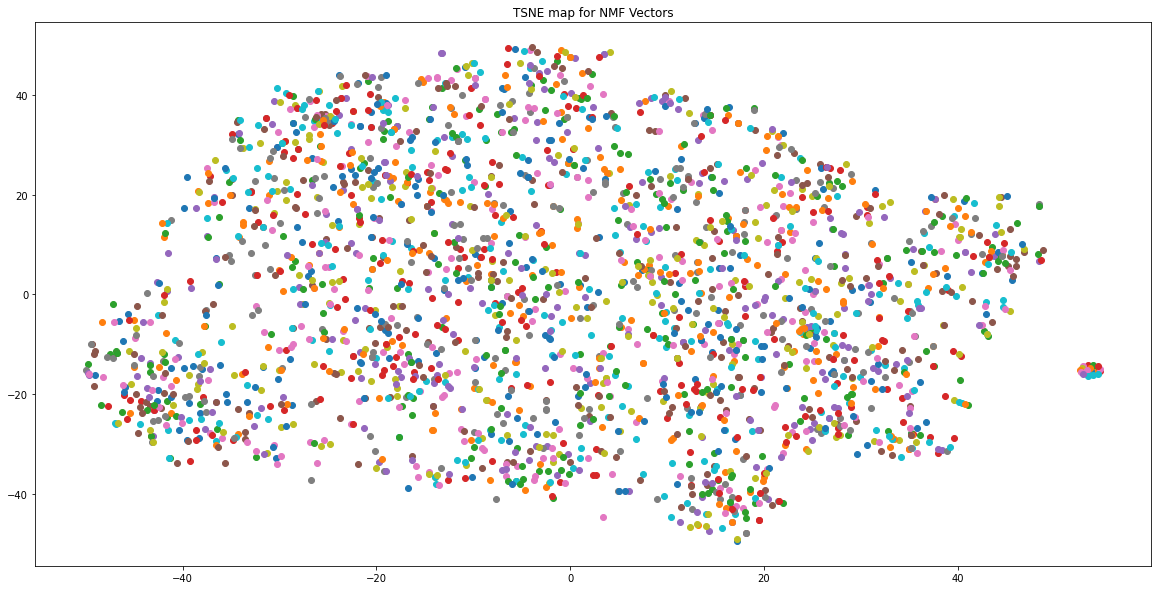

In [67]:
x, y = [], []
_= [(x.append(value[0]) , y.append(value[1]) ) for value in tsne_comp] 
                     
fig = plt.figure(figsize=(20,10))

start_range, end_range =0,len(x)

for i in range(start_range, end_range-1):
    plt.scatter(x[i],y[i])
    #plt.annotate(labels[i], xy = (x[i],y[i]),  textcoords = 'offset points',ha='right',va='bottom')

plt.title('TSNE map for NMF Vectors')

### Plotting NMF in Bokeh

In [90]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_components]
## Plotting Bokeh plot

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

idx= []

for key,values in  tfidf.vocabulary_.items():
    idx.append(key)
    labels.append(values)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_components), plot_width=700, plot_height=700)
plot.scatter(x=x, y=y, color = colormap[0:10] )

for i in range(n_components):
    label = Label(x=x[i], y=y[i], 
                  text=labels[i],text_color=colormap[i]   )
    plot.add_layout(label)
    
show(plot)

### Show the embedding map for LDA

In [68]:
n_components = 20
cv = CountVectorizer(tokenizer=simple_class_tokenizer,max_features=n_components)
lda = LatentDirichletAllocation(n_components=n_components)
count_vecs = cv.fit_transform(all_text)

lda_vecs = lda.fit_transform(count_vecs)

cv.get_feature_names() 


['bad',
 'best',
 'br',
 'character',
 'characters',
 'film',
 'films',
 'good',
 'great',
 'know',
 'like',
 'love',
 'movie',
 'movies',
 'people',
 'story',
 'think',
 'time',
 'watch',
 'way']

In [69]:
#Showing part of the features for LDA
df = pd.DataFrame(lda_vecs,columns=tfidf.get_feature_names() )
df.head(4)


,bad,best,br,character,characters,film,films,good,great,know,like,love,movie,movies,people,story,think,time,watch,way
0,0.542919,0.005000,0.005000,0.005000,0.005000,0.216090,0.005000,0.005000,0.155991,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000
1,0.422222,0.002941,0.002941,0.133400,0.002941,0.002941,0.002941,0.002941,0.002941,0.200694,0.002941,0.196626,0.002941,0.002941,0.002941,0.002941,0.002941,0.002941,0.002941,0.002941
2,0.008333,0.008333,0.505080,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.183881,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.169372,0.008333
3,0.008333,0.008333,0.647189,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.202811,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


Text(0.5, 1.0, 'Scatter plot for word embedding for the LDA')

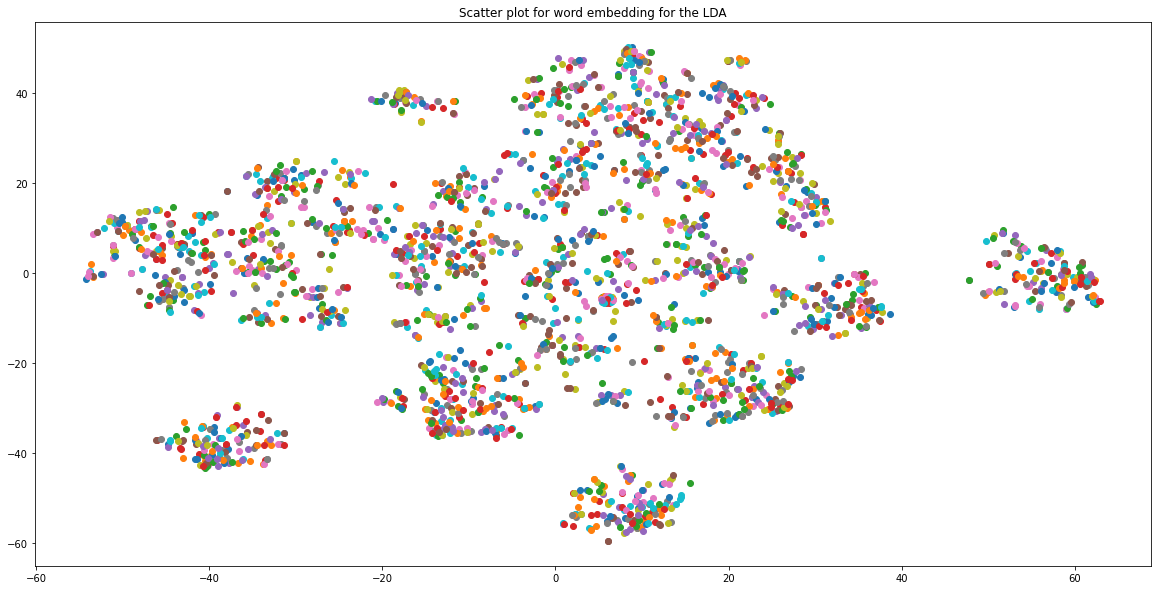

In [89]:

labels = []
tokens = []

tsne = TSNE(n_components=2,perplexity=40)
tsne.fit(tfidf_vecs)

tsne_comp = tsne.fit_transform(df)

for key,values in  cv.vocabulary_.items():
    #print(key,values)
    #tokens.append(tsne.)
    labels.append(key)

x, y = [], []
_= [(x.append(value[0]) , y.append(value[1]) ) for value in tsne_comp] 
                     
fig = plt.figure(figsize=(20,10))

start_range, end_range =0,len(x)

for i in range(start_range, end_range-1):
    plt.scatter(x[i],y[i])
    #plt.annotate(labels[i], xy = (x[i],y[i]),  textcoords = 'offset points',ha='right',va='bottom')

plt.title("Scatter plot for word embedding for the LDA")

### Plotting LDA in Bokeh

In [87]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_components]
## Plotting Bokeh plot

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

idx= []

for key,values in  tfidf.vocabulary_.items():
    idx.append(key)
    labels.append(values)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_components), plot_width=700, plot_height=700)
plot.scatter(x=x, y=y, color = colormap[0:10] )

for i in range(n_components):
    label = Label(x=x[i], y=y[i], 
                  text=labels[i],text_color=colormap[i]   )
    plot.add_layout(label)
    
show(plot)

### Word embedding for the CountVectorizer and TFIDF

In [ ]:
n_components = 10

cv = CountVectorizer(tokenizer=simple_class_tokenizer )
tfidf = TfidfVectorizer(tokenizer=simple_class_tokenizer)

nmf = NMF(n_components=n_components)
lda = LatentDirichletAllocation(n_components=n_components)

# count_vecs = cv.fit_transform(all_reviews)
# tfidf_vecs = tfidf.fit_transform(all_reviews)

nmf_vecs = nmf.fit_transform(tfidf_vecs)
lda_vecs = lda.fit_transform(count_vecs)


In [239]:
count_words, tfidf_words, nmf_wrods, lda_words = count_vecs.T,tfidf_vecs.T, nmf.components_.T, lda.components_.T

In [240]:
#Showing part of the features for CV
df = pd.DataFrame(count_vecs.todense(),columns=cv.get_feature_names()  )
df.iloc[:5,50:60]



,abortion,abound,abounding,abounds,abraham,abrasive,abrasiveness,abre,abril,abroad
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [279]:
#Showing part of the features for TFIDF
df = pd.DataFrame(tfidf_vecs.todense(),columns=tfidf.get_feature_names()  )
df.shape

(2499, 26760)

In [280]:
df.iloc[:5,50:60]

,abortion,abound,abounding,abounds,abraham,abrasive,abrasiveness,abre,abril,abroad
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Coscine similarity of rep:


[[1.         0.37655916 0.18924879 0.44186113 0.38985921 0.32591993
  0.13155812 0.04686243]
 [0.37655916 1.         0.13332342 0.45621268 0.41414202 0.34683672
  0.18312877 0.06787191]
 [0.18924879 0.13332342 1.         0.1581552  0.21390403 0.07105097
  0.02224861 0.        ]
 [0.44186113 0.45621268 0.1581552  1.         0.26797742 0.37147947
  0.21259491 0.05721717]
 [0.38985921 0.41414202 0.21390403 0.26797742 1.         0.25696393
  0.09716894 0.04900215]
 [0.32591993 0.34683672 0.07105097 0.37147947 0.25696393 1.
  0.119109   0.        ]
 [0.13155812 0.18312877 0.02224861 0.21259491 0.09716894 0.119109
  1.         0.05198752]
 [0.04686243 0.06787191 0.         0.05721717 0.04900215 0.
  0.05198752 1.        ]]


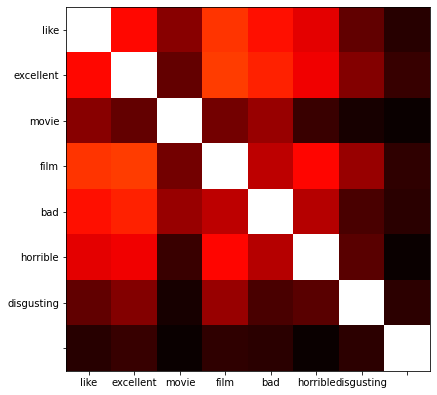

Coscine similarity of rep:


[[1.         0.3087599  0.16467516 0.40762746 0.34299136 0.26769951
  0.09913407 0.03482822]
 [0.3087599  1.         0.11413285 0.40551309 0.34154839 0.27765677
  0.16312939 0.05529301]
 [0.16467516 0.11413285 1.         0.13754573 0.16572938 0.04629876
  0.01619101 0.        ]
 [0.40762746 0.40551309 0.13754573 1.         0.24021272 0.34545608
  0.22095841 0.06026052]
 [0.34299136 0.34154839 0.16572938 0.24021272 1.         0.19494999
  0.09408354 0.04780571]
 [0.26769951 0.27765677 0.04629876 0.34545608 0.19494999 1.
  0.1191954  0.        ]
 [0.09913407 0.16312939 0.01619101 0.22095841 0.09408354 0.1191954
  1.         0.0708516 ]
 [0.03482822 0.05529301 0.         0.06026052 0.04780571 0.
  0.0708516  1.        ]]


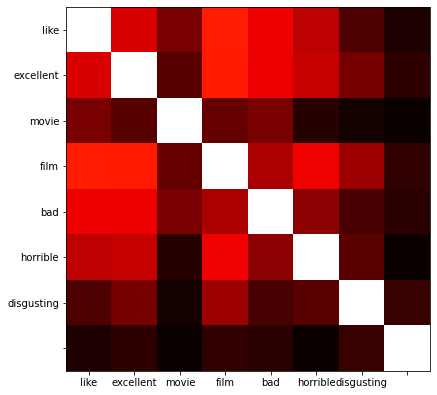

Coscine similarity of rep:


[[1.00000000e+00 9.29981807e-02 7.11379533e-01 3.96545520e-01
  4.23622764e-01 5.14596776e-01 2.43922414e-01 2.28326854e-01]
 [9.29981807e-02 1.00000000e+00 9.22469840e-02 8.19437409e-03
  1.04912562e-02 4.05386619e-02 9.00307238e-01 9.20364547e-01]
 [7.11379533e-01 9.22469840e-02 1.00000000e+00 8.82807025e-02
  3.53551631e-01 0.00000000e+00 3.18076978e-02 1.16937338e-01]
 [3.96545520e-01 8.19437409e-03 8.82807025e-02 1.00000000e+00
  1.38809084e-04 6.95002500e-02 4.03314041e-01 2.83809826e-01]
 [4.23622764e-01 1.04912562e-02 3.53551631e-01 1.38809084e-04
  1.00000000e+00 0.00000000e+00 2.55633108e-03 2.50612290e-01]
 [5.14596776e-01 4.05386619e-02 0.00000000e+00 6.95002500e-02
  0.00000000e+00 1.00000000e+00 1.87189004e-01 0.00000000e+00]
 [2.43922414e-01 9.00307238e-01 3.18076978e-02 4.03314041e-01
  2.55633108e-03 1.87189004e-01 1.00000000e+00 9.36582124e-01]
 [2.28326854e-01 9.20364547e-01 1.16937338e-01 2.83809826e-01
  2.50612290e-01 0.00000000e+00 9.

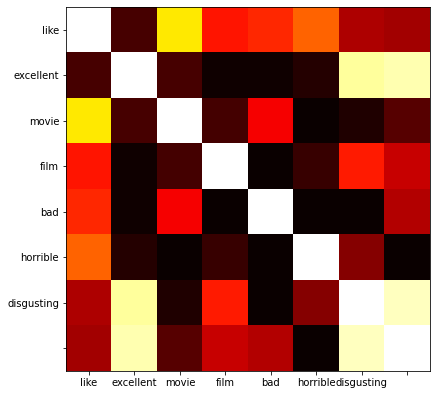

Coscine similarity of rep:


[[1.         0.9875345  0.9457641  0.93854155 0.96932409 0.91537433
  0.91043589 0.83886604]
 [0.9875345  1.         0.89942739 0.96525554 0.9280312  0.96057189
  0.95566572 0.84045044]
 [0.9457641  0.89942739 1.         0.85102995 0.95267009 0.77314055
  0.77107868 0.70381247]
 [0.93854155 0.96525554 0.85102995 1.         0.86930567 0.97190059
  0.95279846 0.73160385]
 [0.96932409 0.9280312  0.95267009 0.86930567 1.         0.81409772
  0.79458121 0.8240161 ]
 [0.91537433 0.96057189 0.77314055 0.97190059 0.81409772 1.
  0.99338983 0.79265706]
 [0.91043589 0.95566572 0.77107868 0.95279846 0.79458121 0.99338983
  1.         0.78986119]
 [0.83886604 0.84045044 0.70381247 0.73160385 0.8240161  0.79265706
  0.78986119 1.        ]]


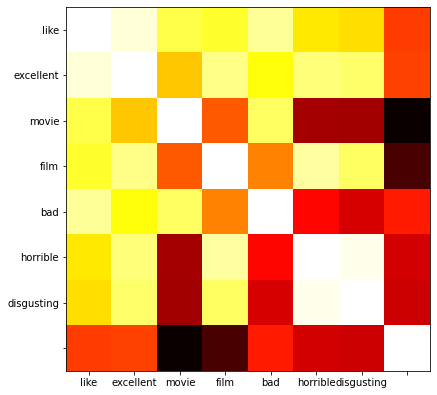

In [ ]:
# implement embedding with smaller corp

seed_words = ['good','like','excellent','movie','film','bad','horrible','disgusting']
seed_idx = [cv.vocabulary_[word] for word in seed_words]
for i, rep in enumerate( [count_words, tfidf_words, nmf_wrods, lda_words ]):
    fig = plt.figure(figsize =(30,30))
    axs = fig.add_subplot(1,4,i+1)

    print(f'Coscine similarity of rep:\n\n')
    cos = cosine_similarity(rep[seed_idx])
    print(cos)
    #d_cos = np.fill_diagonal(cos,0 )
    plt.imshow(cos, cmap='hot', interpolation='nearest')
    axs.set_xticklabels(seed_words)
    axs.set_yticklabels(seed_words)

    plt.show()  

### Results
In my presentation means lighter colors are more similar. 
Since my positive words are on the left of the matix and negative words are in the right of the list, I see in LDA postive words match with the positive word a lot more. I also see most of the negative word match with negative but less of positive match with the negative 

therefore, i feel that LDA is giving the best results 

## Explaination 

What have you learned from this exercise? How does the GloVe vector representation match what you'd expect? How about the NMF/LDA representations? Do you have any sense why this might be? 

Include your response here

# LSTM sentiment prediction model
During classes this week, we went through the code below for designing and training an LSTM model for predicting sentiment.  We outlined some of the parameters that can be tweaked in this design.  Try tweaking some of these parameters and assessing the results.

Suggested tweaks:
- NN models tend to perform better with more iterations through the data.  Try increasing the number of epochs of training
- Dropout is one way to reduce overfitting in the model.  Try and tweak the dropout rate and see how it affects loss and accuracy
- Smaller batch sizes may also be a way to avoid overfitting.  Try and tweak the batch size and assess
- Learning rate adjusts how much the model learns from any given batch.  Increasing it might reduce training time.  Decreasing it might reduce overfitting.  Tweak it and see.

## Creating base LSTM 
>> From Provided code as instructed in the class

### Loading data

In [93]:
# you will need to change this to where ever the file is stored
data_location = './assignment_1_reviews.pkl'
with open(data_location, 'rb') as f:
    all_text = pickle.load(f)
neg, pos = all_text.values()
# join all reviews
all_reviews = np.array(neg+pos)
# create binary indicator for positive review
is_positive = np.array([0]*len(neg)+[1]*len(pos))

### Preprocessing as suggested in the class

In [110]:
# set the seed for numpy
np.random.seed(seed=42)

# shuffle, just for safety
shuffled_idxs = np.random.choice(range(len(all_reviews)), size=len(all_reviews),replace=False)
all_reviews = all_reviews[shuffled_idxs]
is_positive = is_positive[shuffled_idxs]

# sample random 70% for fitting model (training)
# we'll also add a validation set, for checking the progress of the model during training
# 30% will be simulating "new observations" (testing)
pct_train = 0.7
train_bool = np.random.random(len(all_reviews))<=pct_train
reviews_train = all_reviews[train_bool]
reviews_test = all_reviews[~train_bool]
is_positive_train = is_positive[train_bool]
is_positive_test = is_positive[~train_bool]


# making a validation set
pct_val = 0.3
val_idxs = np.random.random(size=len(reviews_train))<=pct_val
is_positive_val = is_positive_train[val_idxs]
is_positive_val.shape
reviews_val = reviews_train[val_idxs]

# reconfigure train so that it doesn't include validation
reviews_train = reviews_train[~val_idxs]
is_positive_train = is_positive_train[~val_idxs]
print(len(reviews_train), len(reviews_val), len(reviews_test))

1233 535 731


#### Parsing the train, test, and 

In [97]:
all_reviews.shape, reviews_train.shape, reviews_test.shape, reviews_val.shape

((2499,), (1233,), (731,), (535,))

In [100]:
is_positive.shape, is_positive_train.shape,is_positive_test.shape, is_positive_val.shape

((2499,), (1233,), (731,), (535,))

In [101]:
from sklearn.model_selection import train_test_split

#### Alternative code for train_test_split

>>> We will further split validation and training by 30% at the time of model.fit

>>> Using code provided in the class though

In [107]:
reviews_train ,  reviews_test, is_positive_train, is_positive_test = \
train_test_split(all_reviews, is_positive, test_size =.3, random_state= 0)

In [108]:
all_reviews.shape, reviews_train.shape, reviews_test.shape, reviews_val.shape

((2499,), (1749,), (750,), (535,))

In [109]:
is_positive.shape, is_positive_train.shape,is_positive_test.shape, is_positive_val.shape

((2499,), (1749,), (750,), (535,))

### Tokenize the parsed data

In [111]:
# transform all data to work with model
# tokenizing ahead of time for easier match with word idx
parsed_train = [simple_class_tokenizer(str(d)) for d in reviews_train]
parsed_val = [simple_class_tokenizer(str(d)) for d in reviews_val]
parsed_test = [simple_class_tokenizer(str(d)) for d in reviews_test]

In [112]:

# this formulation works if you have previously tokenized
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, min_df=0.01)
# **important** just fit on trained: prevents information from test in training 
cv.fit(parsed_train)
# get out the vocab
vocab = cv.vocabulary_
print("Size of vocab:", len(vocab))

Size of vocab: 1523


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### Making data fix length and padding the sequence

In [113]:
# need to adapt vocab, leave space for padding
vocab = dict([(v, vocab[v]+2) for v in vocab])
vocab['_UNK'] = 1
vocab['_PAD'] = 0

In [114]:
parsed_train = doc_to_index(parsed_train, vocab)
padded_train = pad_sequence(parsed_train)
parsed_val = doc_to_index(parsed_val, vocab)
padded_val = pad_sequence(parsed_val)
parsed_test = doc_to_index(parsed_test, vocab)
padded_test = pad_sequence(parsed_test)
# onehot encoding
# create a "weight matrix" for using Embedding layer in PyTorch
onehot_matrix = np.zeros(shape=(len(vocab), len(vocab)))
np.fill_diagonal(onehot_matrix, 1)

### construct dataset using Pytorch

In [115]:
# construct datasets for loading by PyTorch
train_data = TensorDataset(torch.from_numpy(padded_train), torch.from_numpy(is_positive_train))
val_data = TensorDataset(torch.from_numpy(padded_val), torch.from_numpy(is_positive_val))
test_data = TensorDataset(torch.from_numpy(padded_test), torch.from_numpy(is_positive_test))

batch_size = 100

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,
                         drop_last=True) # this is to keep the size consistent
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size,
                       drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,
                        drop_last=True)

### Initiatiing the Sentiment Model provided 

 


### Build a function to train the model 

In [146]:
def build_and_train_model( lr=0.005, epochs = 1,batch_size=100, dropout_rate=.05):

    global model 


    model_params = {'weight_matrix': onehot_matrix,
               'output_size': 1,
               'hidden_dim': 512,
               'n_layers': 2,
               'embedding_dim': 400,
               'dropout_prob': dropout_rate}

    model = SentimentNet(**model_params)

    model.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # increasing this will make the training take a while on CPU
    # decrease to 5 if it's taking too long

    counter = 0
    print_every = 5
    clip = 5 # gradient clip, default value
    valid_loss_min = np.Inf

    model.train()
    for i in range(epochs):
        h = model.init_hidden(batch_size)
        for inputs, labels in train_loader:
            counter += 1
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the gradients, otherwise will collect them
            model.zero_grad()
            output, h = model(inputs, h)
            # squeeze removes dimensions of size 1
            # output has an additional dimension, need to make it comparable
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            # gradient clipping - avoids updates that are unreasonably large
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            
            if counter%print_every == 0:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                for inp, lab in val_loader:
                    val_h = tuple([each.data for each in val_h])
                    inp, lab = inp.to(device), lab.to(device)
                    out, val_h = model(inp, val_h)
                    val_loss = criterion(out.squeeze(), lab.float())
                    val_losses.append(val_loss.item())
                    
                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                    "Step: {}...".format(counter),
                    "Loss: {:.6f}...".format(loss.item()),
                    "Val Loss: {:.6f}".format(np.mean(val_losses)))
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), './state_dict.pt')
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                    valid_loss_min = np.mean(val_losses)
    return model

In [129]:
def predict_and_valuate(model,batch_size=32):
    # pytorch LSTM model
    model.load_state_dict(torch.load('./state_dict.pt'))
    h = model.init_hidden(batch_size)
    num_correct = 0
    model.eval()
    for inputs, labels in test_loader:
        h = tuple([each.data for each in h])
        inputs, labels = inputs.to(device), labels.to(device)
        output, h = model(inputs, h)
        # takes output, rounds to 0/1
        pred = torch.round(output.squeeze())
        # take the correct labels, check against preds
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        # sum the number of correct
        num_correct += np.sum(correct)
    # calc accuracy
    test_acc = num_correct/len(test_loader.dataset)
    print('LSTM accuracy:', test_acc)

## Running the base model

In [124]:
model = build_and_train_model( lr=0.005, epochs = 1,batch_size=100, dropout_rate=.05)

Epoch: 1/1... Step: 5... Loss: 0.693312... Val Loss: 0.691963
Validation loss decreased (inf --> 0.691963).  Saving model ...
Epoch: 1/1... Step: 10... Loss: 0.695095... Val Loss: 0.692060


### Predict the test results 

In [128]:
predict_and_valuate(model, 100)

LSTM accuracy: 0.47332421340629277


## Increasing number of epochs

In [130]:
model = build_and_train_model( lr=0.005, epochs = 2,batch_size=100, dropout_rate=.05)

Epoch: 1/2... Step: 5... Loss: 0.697521... Val Loss: 0.692589
Validation loss decreased (inf --> 0.692589).  Saving model ...
Epoch: 1/2... Step: 10... Loss: 0.697914... Val Loss: 0.691622
Validation loss decreased (0.692589 --> 0.691622).  Saving model ...
Epoch: 2/2... Step: 15... Loss: 0.704569... Val Loss: 0.692962
Epoch: 2/2... Step: 20... Loss: 0.705280... Val Loss: 0.692515


In [131]:
predict_and_valuate(model, 100)

LSTM accuracy: 0.493844049247606


## Change the dropout rate and see the performance 

In [132]:
model = build_and_train_model( lr=0.005, epochs = 2,batch_size=100, dropout_rate=.02)

Epoch: 1/2... Step: 5... Loss: 0.701760... Val Loss: 0.699698
Validation loss decreased (inf --> 0.699698).  Saving model ...
Epoch: 1/2... Step: 10... Loss: 0.696551... Val Loss: 0.734195
Epoch: 2/2... Step: 15... Loss: 0.691661... Val Loss: 0.697050
Validation loss decreased (0.699698 --> 0.697050).  Saving model ...
Epoch: 2/2... Step: 20... Loss: 1.318081... Val Loss: 0.843580


In [133]:
predict_and_valuate(model, 100)


LSTM accuracy: 0.46785225718194257


>>> lowering dropout rate from .5 to .2 decreased the performance so the .5 is a better drop out rate

## Smalller batch size - Change batch size

In [147]:
model = build_and_train_model( lr=0.005, epochs = 2,batch_size=50, dropout_rate=.02)

Epoch: 1/2... Step: 5... Loss: 0.717739... Val Loss: 0.693809
Validation loss decreased (inf --> 0.693809).  Saving model ...
Epoch: 1/2... Step: 10... Loss: 0.816908... Val Loss: 0.707542
Epoch: 1/2... Step: 15... Loss: 0.735946... Val Loss: 0.695835
Epoch: 1/2... Step: 20... Loss: 0.693925... Val Loss: 0.697131
Epoch: 2/2... Step: 25... Loss: 0.699956... Val Loss: 0.696316
Epoch: 2/2... Step: 30... Loss: 0.698216... Val Loss: 0.691026
Validation loss decreased (0.693809 --> 0.691026).  Saving model ...
Epoch: 2/2... Step: 35... Loss: 0.702810... Val Loss: 0.699412
Epoch: 2/2... Step: 40... Loss: 0.740765... Val Loss: 0.689394
Validation loss decreased (0.691026 --> 0.689394).  Saving model ...
Epoch: 2/2... Step: 45... Loss: 0.695982... Val Loss: 0.735297


In [149]:
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,
                         drop_last=True) # this is to keep the size consistent
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size,
                       drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,
                        drop_last=True)

In [150]:
predict_and_valuate(model, 50)

LSTM accuracy: 0.4692202462380301


>>> Performance went down 

## learning rate and its affect 

In [134]:
model = build_and_train_model( lr=0.01, epochs = 2,batch_size=100, dropout_rate=.02)

Epoch: 1/2... Step: 5... Loss: 0.756540... Val Loss: 0.694805
Validation loss decreased (inf --> 0.694805).  Saving model ...
Epoch: 1/2... Step: 10... Loss: 0.719416... Val Loss: 0.701810
Epoch: 2/2... Step: 15... Loss: 0.686185... Val Loss: 0.709956
Epoch: 2/2... Step: 20... Loss: 0.788447... Val Loss: 0.749855


In [137]:
predict_and_valuate(model, 100)


LSTM accuracy: 0.48700410396716826


>>> Increase in learning rate gave better performance 

## Provided code

In [116]:
def doc_to_index(docs, vocab):
    # transform docs into series of indices
    docs_idxs = []
    for d in docs:
        w_idxs = []
        for w in d:
            if w in vocab:
                w_idxs.append(vocab[w])
            else:
                # unknown token = 1
                w_idxs.append(1)
        docs_idxs.append(w_idxs)
    return(docs_idxs)

def pad_sequence(seqs, seq_len=200):
    # function for adding padding to ensure all seq same length
    features = np.zeros((len(seqs), seq_len),dtype=int)
    for i, seq in enumerate(seqs):
        if len(seq) != 0:
            features[i, -len(seq):] = np.array(seq)[:seq_len]
    return features

class SentimentNet(nn.Module):
    # sentiment classifier with single LSTM layer + Fully-connected layer, sigmoid activation and dropout
    # adapted from https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/
    def __init__(self,
                 weight_matrix=None,
                 vocab_size=1000, 
                 output_size=1,  
                 hidden_dim=512,
                 embedding_dim=400, 
                 n_layers=2, 
                 dropout_prob=0.5):
        super(SentimentNet, self).__init__()
        # size of the output, in this case it's one input to one output
        self.output_size = output_size
        # number of layers (default 2) one LSTM layer, one fully-connected layer
        self.n_layers = n_layers
        # dimensions of our hidden state, what is passed from one time point to the next
        self.hidden_dim = hidden_dim
        # initialize the representation to pass to the LSTM
        self.embedding, embedding_dim = self.init_embedding(
            vocab_size, 
            embedding_dim, 
            weight_matrix)
        # LSTM layer, where the magic happens
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout_prob, batch_first=True)
        # dropout, similar to regularization
        self.dropout = nn.Dropout(dropout_prob)
        # fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        # sigmoid activiation
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        # forward pass of the network
        batch_size = x.size(0)
        # transform input
        embeds = self.embedding(x)
        # run input embedding + hidden state through model
        lstm_out, hidden = self.lstm(embeds, hidden)
        # reshape
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        # dropout certain pct of connections
        out = self.dropout(lstm_out)
        # fully connected layer
        out = self.fc(out)
        # activation function
        out = self.sigmoid(out)
        # reshape
        out = out.view(batch_size, -1)
        out = out[:,-1]
        # return the output and the hidden state
        return out, hidden
    
    def init_embedding(self, vocab_size, embedding_dim, weight_matrix):
        # initializes the embedding
        if weight_matrix is None:
            if vocab_size is None:
                raise ValueError('If no weight matrix, need a vocab size')
            # if embedding is a size, initialize trainable
            return(nn.Embedding(vocab_size, embedding_dim),
                   embedding_dim)
        else:
            # otherwise use matrix as pretrained
            weights = torch.FloatTensor(weight_matrix)
            return(nn.Embedding.from_pretrained(weights),
                  weights.shape[1])
    
    def init_hidden(self, batch_size):
        # initializes the hidden state
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden
    
def train_model(model, train_loader, val_loader, model_params, training_params):
    # utility for running the training process
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=training_params['learning_rate'])
    epochs = training_params['epochs']
    batch_size = training_params['batch_size']
    # print options
    counter = 0
    print_every = 5
    clip = 5
    valid_loss_min = np.Inf
    model.train()
    for i in range(epochs):
        h = model.init_hidden(batch_size)
        for inputs, labels in train_loader:
            counter += 1
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            model.zero_grad()
            output, h = model(inputs, h)
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            if counter%print_every == 0:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                for inp, lab in val_loader:
                    val_h = tuple([each.data for each in val_h])
                    inp, lab = inp.to(device), lab.to(device)
                    out, val_h = model(inp, val_h)
                    val_loss = criterion(out.squeeze(), lab.float())
                    val_losses.append(val_loss.item())

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), './state_dict.pt')
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                    valid_loss_min = np.mean(val_losses)
    return(model)
    
def assess_accuracy(model, test_loader, model_params, training_params):
    # utility for assessing accuracy
    batch_size = training_params['batch_size']
    model.load_state_dict(torch.load('./state_dict.pt'))
    h = model.init_hidden(batch_size)
    num_correct = 0
    model.eval()
    for inputs, labels in test_loader:
        h = tuple([each.data for each in h])
        inputs, labels = inputs.to(device), labels.to(device)
        output, h = model(inputs, h)
        # takes output, rounds to 0/1
        pred = torch.round(output.squeeze())
        # take the correct labels, check against preds
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        # sum the number of correct
        num_correct += np.sum(correct)
    # calc accuracy
    test_acc = num_correct/len(test_loader.dataset)
    print('LSTM accuracy:', test_acc)